In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Why does differential privacy matter in healthcare?

Differential privacy matters in healthcare because it enables the use of sensitive patient data while safeguarding individual privacy.

- Often contains PII
- Have to adhere to HIPAA
- Sensitive Data often required to conduct meaningful analysis and/or predictions


## EDA

In [3]:
heart_disease_data = pd.read_csv('./data/heart_disease_uci.csv').set_index('id')
heart_disease_data

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
id,,,,,,,,,,,,,,,
1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2


In [4]:
missing_values = heart_disease_data.isnull().sum()
missing_values_percentage = (missing_values / len(heart_disease_data)) * 100
missing_values_percentage[missing_values_percentage > 0]


trestbps     6.413043
chol         3.260870
fbs          9.782609
restecg      0.217391
thalch       5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
dtype: float64

In [5]:
heart_disease_data = heart_disease_data.drop(columns=['dataset', 'slope', 'ca', 'thal'], errors='ignore')

heart_disease_data = heart_disease_data.dropna()

heart_disease_data.isnull().sum().sum()


0

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


obj = heart_disease_data.select_dtypes(include=['object']).columns
bools = heart_disease_data.select_dtypes(include=['bool']).columns
for col in obj:
    heart_disease_data[col] = LabelEncoder().fit_transform(heart_disease_data[col])

for col in bools:
    heart_disease_data[col] = OneHotEncoder().fit_transform(heart_disease_data[col])

heart_disease_data['num'] = heart_disease_data['num'].apply(lambda x: 1 if x > 0 else 0)

X = heart_disease_data.drop(columns=['num'])
y = heart_disease_data['num']



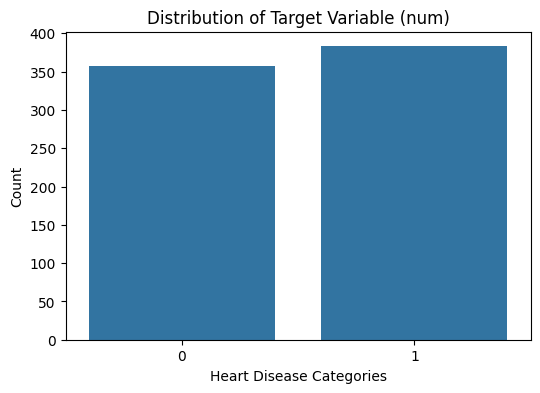

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='num', data=heart_disease_data)
plt.title('Distribution of Target Variable (num)')
plt.xlabel('Heart Disease Categories')
plt.ylabel('Count')
plt.show()

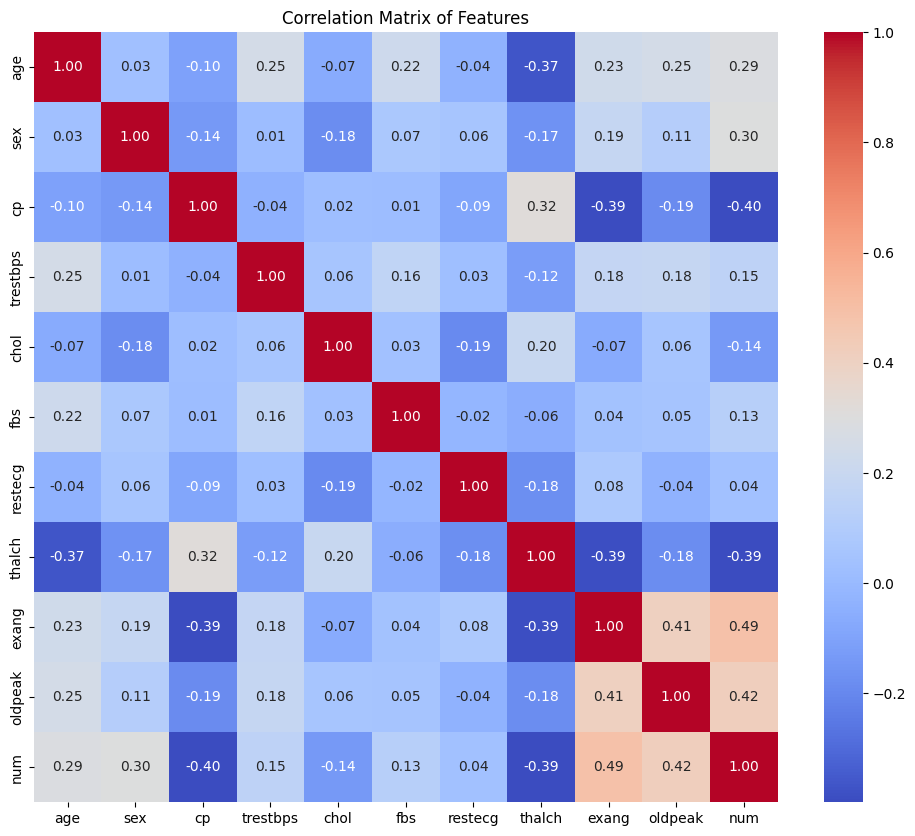

In [8]:
plt.figure(figsize=(12, 10))
correlation_matrix = heart_disease_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
heart_disease_data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,53.097297,0.764865,0.787838,132.754054,220.136486,0.150000,0.925676,138.744595,0.400000,0.894324,0.517568
std,9.408127,0.424370,0.950529,18.581250,93.614555,0.357313,0.627421,25.846082,0.490229,1.087160,0.500029
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-1.000000,0.000000
25%,46.000000,1.000000,0.000000,120.000000,197.000000,0.000000,1.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,0.000000,130.000000,231.000000,0.000000,1.000000,140.000000,0.000000,0.500000,1.000000
75%,60.000000,1.000000,2.000000,140.000000,271.000000,0.000000,1.000000,159.250000,1.000000,1.500000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,1.000000


## Standard Logistic Regression

Equation: 
$$
P(y=1 \mid x; \theta) = \frac{1}{1 + e^{-\theta^\top x}}
$$

Gradient: 

$$
L(\theta) = \sum_{i=1}^n \left( y_i \log \left( P(y_i \mid x_i; \theta) \right) + (1 - y_i) \log \left( 1 - P(y_i \mid x_i; \theta) \right) \right)
$$

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
from sklearn import metrics

def plot_confusion_matrix(actual, predicted):

    num_categories=len(set(actual))

    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = np.arange(num_categories))

    cm_display.plot()
    plt.show()

CE loss: 0.40081806539219716
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        75
           1       0.82      0.86      0.84        73

    accuracy                           0.84       148
   macro avg       0.84      0.84      0.84       148
weighted avg       0.84      0.84      0.84       148



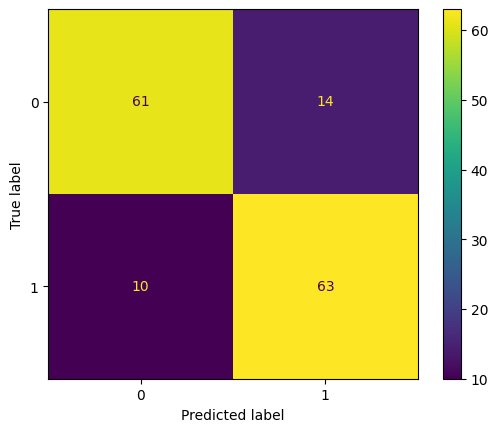

In [12]:
log_reg = LogisticRegression(class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)
standard_log_loss = log_loss(y_test, y_pred_proba)

print(f'CE loss: {standard_log_loss}')
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [13]:

err_nonprivate = 1 - metrics.accuracy_score(y_test, y_pred)

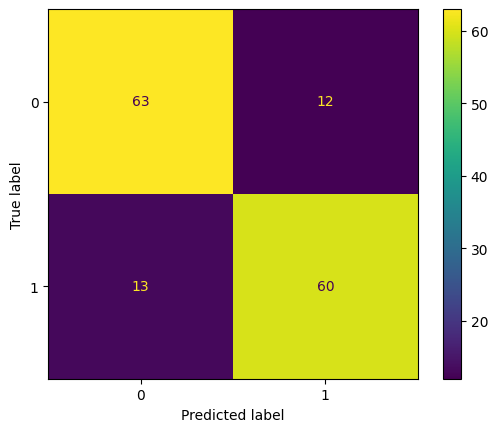

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        75
           1       0.83      0.82      0.83        73

    accuracy                           0.83       148
   macro avg       0.83      0.83      0.83       148
weighted avg       0.83      0.83      0.83       148



In [14]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# Fit the model on the training data
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

## DPML

In [15]:
dim = X.shape[1]
n = X.shape[0]

# the following bounds are chosen independent to the data
x_bound = 1
y_bound = 1

if not isinstance(X, np.ndarray):
    X = X.to_numpy()

if not isinstance(y, np.ndarray):
    y = y.to_numpy()

if not isinstance(X_train, np.ndarray):
    X_train = X_train.to_numpy()

if not isinstance(y_train, np.ndarray):
    y_train = y_train.to_numpy()

if not isinstance(X_test, np.ndarray):
    X_test = X_test.to_numpy()

if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()


In [16]:
def CE(score,y):
    # numerically efficient vectorized implementation of CE loss
    log_phat = np.zeros_like(score)
    log_one_minus_phat = np.zeros_like(score)
    mask = score > 0
    log_phat[mask] = - np.log( 1 + np.exp(-score[mask]))
    log_phat[~mask] = score[~mask] - np.log( 1 + np.exp(score[~mask]))
    log_one_minus_phat[mask] = -score[mask] - np.log( 1 + np.exp(-score[mask]))
    log_one_minus_phat[~mask] = - np.log( 1 + np.exp(score[~mask]))

    return -y*log_phat-(1-y)*log_one_minus_phat

def loss(theta):
    return np.sum(CE(X@theta,y))/n

def err(theta):
    return np.sum((X@theta > 0) != y) / n

def err_yhat(yhat):
    return np.sum((yhat != y)) / n

In [59]:
!pip install diffprivlib


In [ ]:
from diffprivlib.models import LogisticRegression as DPLogisticRegression

epsilons = np.logspace(-3, 3, 500)

num_runs = 40

# Initialize results storage
dp_errors = {epsilon: [] for epsilon in epsilons}
dp_accs = {epsilon: [] for epsilon in epsilons}


# Train and evaluate the model 40 times for each epsilon
for epsilon in epsilons:
    for _ in range(num_runs):
        dp_model = DPLogisticRegression(epsilon=epsilon, data_norm=2.0)
        dp_model.fit(X_train, y_train)
        
        # Predict and calculate metrics
        y_pred_dp = dp_model.predict(X_test)
        dp_error = log_loss(y_test, y_pred_dp, labels=[0, 1])
        dp_acc = np.mean(y_test == y_pred_dp)
        
        # Store results
        dp_errors[epsilon].append(dp_error)
        dp_accs[epsilon].append(dp_acc)

# Compute average metrics for each epsilon
avg_errors = {epsilon: np.mean(dp_errors[epsilon]) for epsilon in epsilons}
avg_accs = {epsilon: np.mean(dp_accs[epsilon]) for epsilon in epsilons}

In [61]:
import pickle
pickle.dump((epsilons, np.mean(y_test == y_pred), list(avg_accs.values())), open("lr_accuracy_500.p", "wb" ) )

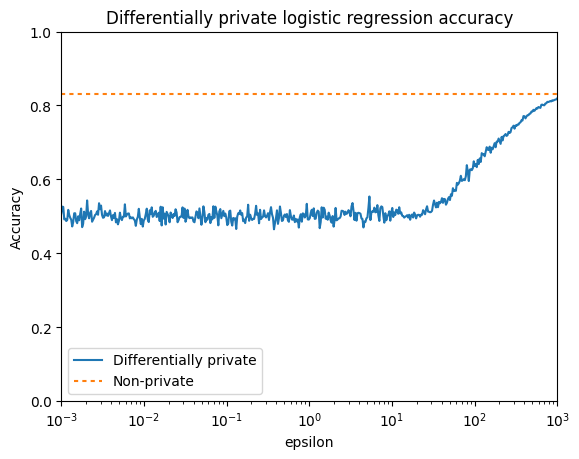

In [49]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, accuracy = pickle.load(open("lr_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

In [58]:
for i, (key, value) in enumerate(avg_accs.items()):
    if i % 100 == 0 or i == 499:
        print(f"{key}: {value}")
print(baseline)       

0.001: 0.5079054054054054
0.01593693530381775: 0.5259459459459459
0.25398590687807265: 0.5176351351351351
4.047756965997322: 0.5087162162162161
64.508840892677: 0.5899324324324324
1000.0: 0.8193918918918918
0.831081081081081


In [60]:
import pickle
pickle.dump((epsilons, log_loss(y_test, y_pred), list(avg_errors.values())), open("lr_loss_500.p", "wb" ) )

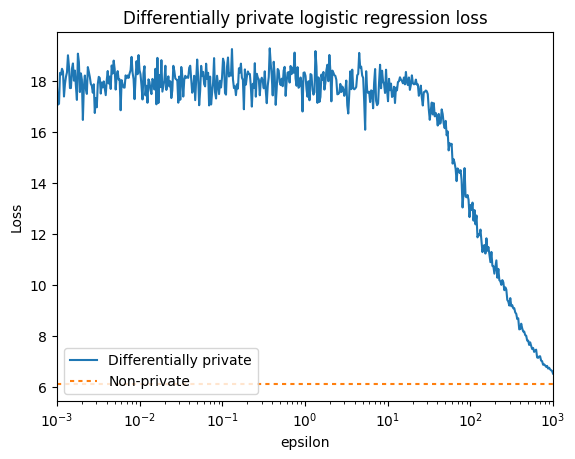

In [65]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, loss = pickle.load(open("lr_loss_500.p", "rb"))

plt.semilogx(epsilons, loss, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression loss")
plt.xlabel("epsilon")
plt.ylabel("Loss")
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

In [67]:
for i, (key, value) in enumerate(avg_errors.items()):
    if i % 100 == 0 or i == 499:
        print(f"{key}: {value}")
print(baseline)    

0.001: 17.73688700222569
0.01593693530381775: 17.08664001203013
0.25398590687807265: 17.386191996277525
4.047756965997322: 17.70766241839668
64.508840892677: 14.780333271523784
1000.0: 6.509776047912848
6.088454964377897


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB as DPGaussianNB

    
epsilons = np.logspace(-3, 3, 500)
bounds = (X_train.min(axis=0), X_train.max(axis=0))

num_runs = 40 # Computational Efficiency

# Initialize results storage
dp_errors = {epsilon: [] for epsilon in epsilons}
dp_accs = {epsilon: [] for epsilon in epsilons}


# Train and evaluate the model 40 times for each epsilon
for i, epsilon in enumerate(epsilons, start=1):
    for _ in range(num_runs):
        dp_model = DPGaussianNB(epsilon=epsilon, bounds = bounds)
        dp_model.fit(X_train, y_train)
        
        # Predict and calculate metrics
        y_pred_dp = dp_model.predict(X_test)
        dp_error = log_loss(y_test, y_pred_dp, labels=[0, 1])
        dp_acc = np.mean(y_test == y_pred_dp)
        
        # Store results
        dp_errors[epsilon].append(dp_error)
        dp_accs[epsilon].append(dp_acc)
        
    if i%50 == 0:
        print(f'Training {i/5}% done.')

# Compute average metrics for each epsilon
avg_errors = {epsilon: np.mean(dp_errors[epsilon]) for epsilon in epsilons}
avg_accs = {epsilon: np.mean(dp_accs[epsilon]) for epsilon in epsilons}

Training 10.0% done.
Training 20.0% done.
Training 30.0% done.
Training 40.0% done.
Training 50.0% done.
Training 60.0% done.
Training 70.0% done.
Training 80.0% done.
Training 90.0% done.
Training 100.0% done.


In [91]:
import pickle
pickle.dump((epsilons, np.mean(y_test == y_pred), list(avg_accs.values())), open("gnb_accuracy_500.p", "wb" ) )

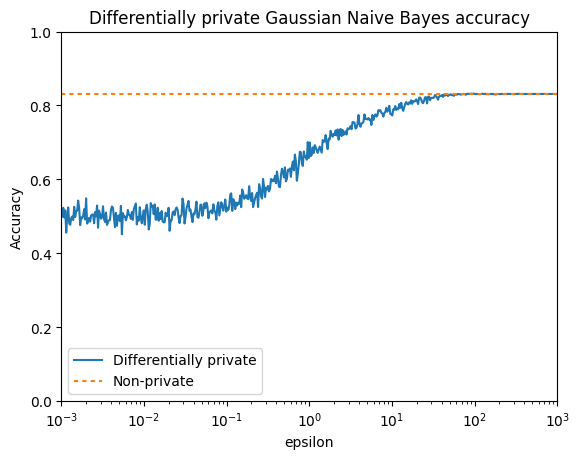

In [92]:
epsilons, baseline, accuracy = pickle.load(open("gnb_accuracy_500.p", "rb"))

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private Gaussian Naive Bayes accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

In [93]:
for i, (key, value) in enumerate(avg_accs.items()):
    if i % 100 == 0 or i == 499:
        print(f"{key}: {value}")
print(baseline)  

0.001: 0.5214527027027027
0.01593693530381775: 0.4923986486486486
0.25398590687807265: 0.5775337837837837
4.047756965997322: 0.7494932432432433
64.508840892677: 0.8309121621621621
1000.0: 0.831081081081081
0.831081081081081


In [94]:
pickle.dump((epsilons, log_loss(y_test, y_pred), list(avg_errors.values())), open("gnb_loss_500.p", "wb" ) )
epsilons, baseline, loss = pickle.load(open("gnb_loss_500.p", "rb"))


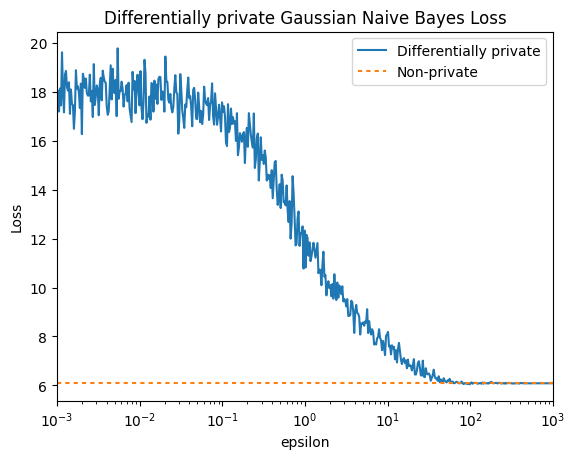

In [95]:
plt.semilogx(epsilons, loss, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * log_loss(y_test, y_pred), dashes=[2,2], label="Non-private")
plt.title("Differentially private Gaussian Naive Bayes Loss")
plt.xlabel("epsilon")
plt.ylabel("Loss")

plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=0)
plt.show()

In [96]:
for i, (key, value) in enumerate(avg_errors.items()):
    if i % 100 == 0 or i == 499:
        print(f"{key}: {value}")
print(baseline)    

0.001: 17.248592914082586
0.01593693530381775: 18.29580716795558
0.25398590687807265: 15.227225865909123
4.047756965997322: 9.02917871217242
64.508840892677: 6.0945434193422745
1000.0: 6.088454964377897
6.088454964377897


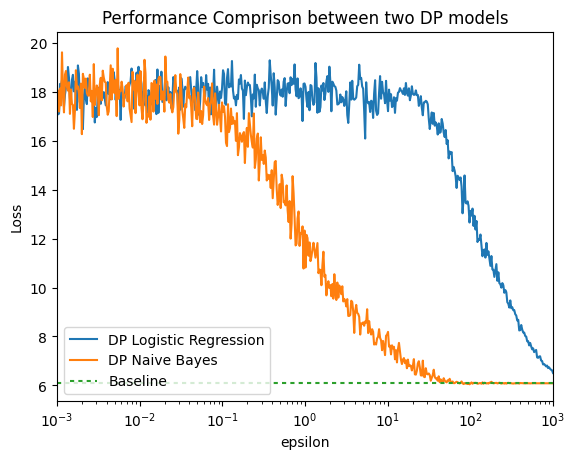

In [101]:
epsilons, baseline_gnb, loss_gnb = pickle.load(open("gnb_loss_500.p", "rb"))
epsilons, baseline_lr, loss_lr = pickle.load(open("lr_loss_500.p", "rb"))

plt.semilogx(epsilons, loss_lr, label="DP Logistic Regression")
plt.semilogx(epsilons, loss_gnb, label="DP Naive Bayes")
plt.plot(epsilons, np.ones_like(epsilons) * log_loss(y_test, y_pred), dashes=[2,2], label="Baseline")
plt.title("Performance Comprison between two DP models")
plt.xlabel("epsilon")
plt.ylabel("Loss")

plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()